In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Conv2DTranspose
from keras.layers import Dropout, Flatten, Activation, UpSampling2D, Reshape, concatenate
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

import glob
import shutil

import cv2 
from cv2 import resize, imread, imwrite

import h5py

Using TensorFlow backend.


### Data preprocessing

Upload all data into images and masks.

In [14]:
from cv2 import imread
img_data_path = sorted(glob.glob('/notebooks/b.irina/AxSegmenta/Data/Images/*'))
masks_data_path = sorted(glob.glob('/notebooks/b.irina/AxSegmenta/Data/Masks/*'))

In [21]:
images = np.zeros((len(img_data_path),2048,2048))
for i, file in enumerate(img_data_path):
    img = imread(file, 0) #read in grayscale
    images[i] = img

In [25]:
masks = np.zeros((len(masks_data_path),2048,2048))
for i, file in enumerate(masks_data_path):
    mask = imread(file, 0) #read in grayscale
    masks[i] = mask

Let's look up a few image and mask examples:

In [26]:
def draw_examples(images, masks):
  
    indexes = np.random.randint(images.shape[0], size=6)
    print(indexes)
    fig = plt.figure(figsize=(20, 10))
    position = 1
    for i, index in enumerate(indexes): 
        plt.subplot(3, 4, position)
        plt.title('Histology image ' + str(i))
        plt.imshow(images[index],cmap='gray')
        
        plt.subplot(3,4,position+1)
        plt.title('Manual mask ' + str(i))
        plt.imshow(masks[index],cmap='gray')
        position+=2
        
    plt.tight_layout()
    plt.show()

[169 157  18 131 123  23]


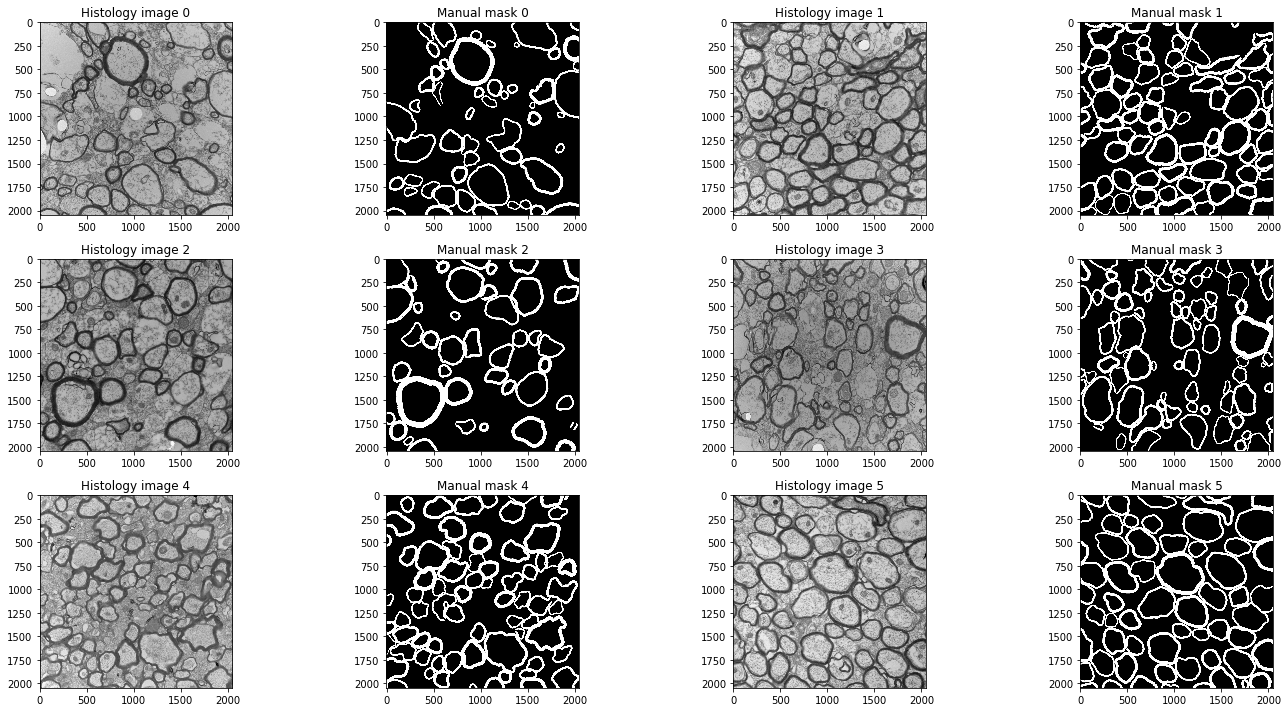

In [27]:
draw_examples(images, masks)

Then we randomly crop 224x224 patches, from each image we crop 100 patches

In [34]:
patch_width = 224
patch_height = 224
patches_num = 100
num_examples = len(images)
width, height = images[0].shape
img_patches = np.zeros((patches_num * num_examples, patch_width, patch_height))
masks_patches = np.zeros((patches_num * num_examples, patch_width, patch_height))

for example in range(num_examples):
    img = images[example]
    mask = masks[example]
    for i in range(patches_num):
        rand_x = np.random.randint(0, width - patch_width +1)
        rand_y = np.random.randint(0, height - patch_height +1)
        top = rand_y
        left = rand_x
        bottom = top + patch_height
        right = left + patch_width
        img_patch = img[top:bottom, left:right]
        mask_patch = mask[top:bottom, left:right]
        imwrite('../Data/Images_patch_224/control_raw_%d.png' %(example*i),img_patch)
        imwrite('../Data/Masks_patch_224/control_raw_%d.png' %(example*i), 
                mask_patch*255)
        img_patches[example*patches_num + i] = img_patch
        masks_patches[example*patches_num + i] = mask_patch


[ 6260 12403  3922 16059 15035  9337]


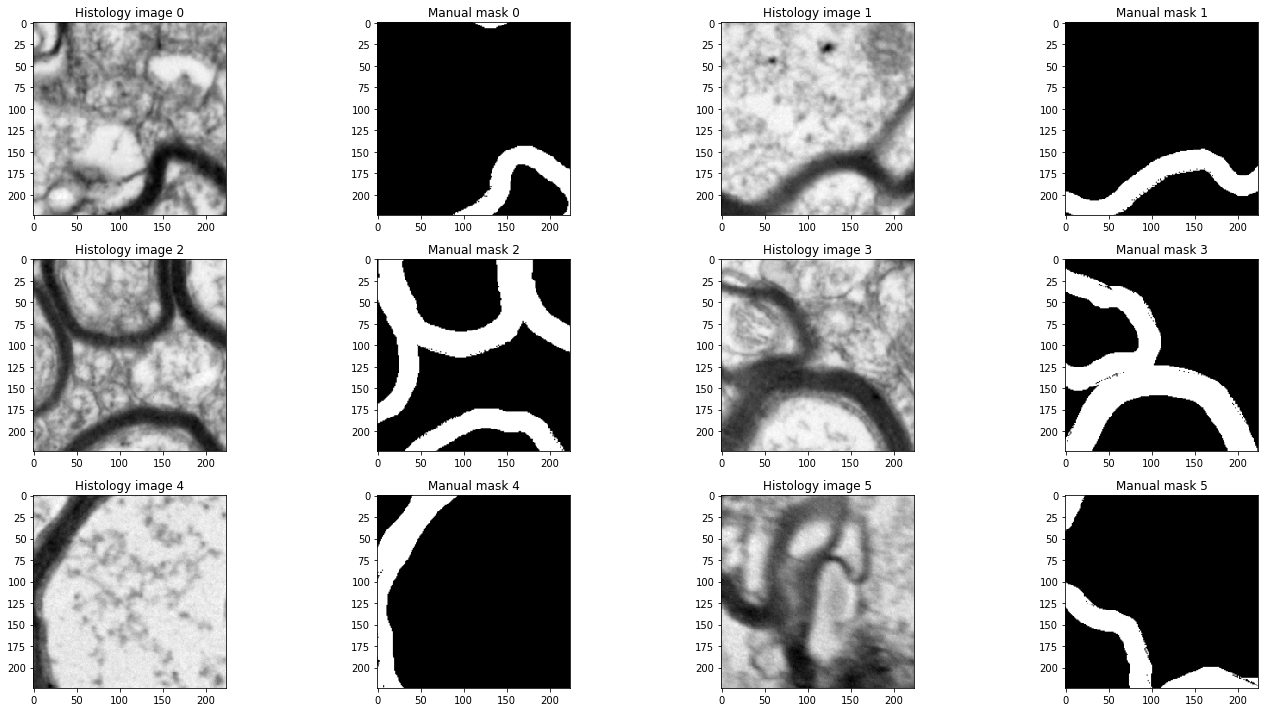

In [50]:
draw_examples(img_patches, masks_patches)

Then we split the dataset into train, valid and test in ration 70:20:10

In [41]:
def data_split(imgs_path, masks_path, basic_path, train_ratio = 0.7, valid_ratio = 0.2, test_ratio = 0.1):
    images_filenames = glob.glob(imgs_path+'*.png')
    masks_filenames = glob.glob(masks_path+'*.png')
    paired_filenames = sorted(list(zip(images_filenames, masks_filenames)))
    # shuffle
    random.shuffle(paired_filenames)
    images_filenames, masks_filenames = zip(*paired_filenames)
    # split data
    total_examples = len(images_filenames)
    train_index = int(total_examples * train_ratio)
    valid_index = train_index + int(total_examples * valid_ratio)

    images_filenames_train, masks_filenames_train = images_filenames[:train_index],\
                                                    masks_filenames[:train_index]

    images_filenames_valid, masks_filenames_valid = images_filenames[train_index:valid_index],\
                                                    masks_filenames[train_index:valid_index]

    images_filenames_test, masks_filenames_test = images_filenames[valid_index:],\
                                                  masks_filenames[valid_index:]

    # save data
    for filename in images_filenames_train:
        shutil.copy2(filename, basic_path+'train/images/')
    for filename in masks_filenames_train:
        shutil.copy2(filename, basic_path+'train/masks/')

    for filename in images_filenames_valid:
        shutil.copy2(filename, basic_path+'valid/images/')
    for filename in masks_filenames_valid:
        shutil.copy2(filename, basic_path+'valid/masks/')

    for filename in images_filenames_test:
        shutil.copy2(filename, basic_path+'test/images/')
    for filename in masks_filenames_test:
        shutil.copy2(filename, basic_path+'test/masks/')

In [47]:
imgs_path = '/notebooks/b.irina/AxSegmenta/Data/Images_patch_224/'
masks_path = '/notebooks/b.irina/AxSegmenta/Data/Masks_patch_224/'
basic_path = '/notebooks/b.irina/AxSegmenta/Data/'
data_split(imgs_path, masks_path)

In [49]:
files_train = glob.glob(basic_path+'train/images/*')
files_test = glob.glob(basic_path+'test/images/*')
files_valid = glob.glob(basic_path+'valid/images/*')
print('There are {} images in train dataset, {} images in validation dataset, {} images in test dataset'.format(len(files_train),len(files_valid),len(files_test)))

There are 4173 images in train dataset, 1192 images in validation dataset, 597 images in test dataset


## Testing ImageDataGenerator, the model and loss function

In [1]:
from data_generator import *

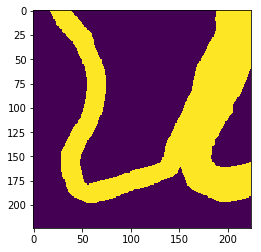

In [12]:
for img, msk in batch_generator(batch_size = 3):
    plt.imshow(img[0].reshape(224,224))
    plt.imshow(msk[0].reshape(224,224))
    break

In [24]:
img_filenames = glob.glob('/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_*')
mask_filenames = glob.glob('/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_*')
paired_filenames = list(zip(img_filenames, mask_filenames))
np.random.shuffle(paired_filenames)
img_filenames, mask_filenames = zip(*paired_filenames)

mask_filenames

('/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_7848.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_5504.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_240.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_8140.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_11398.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_7345.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_3403.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_5886.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_10048.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_9898.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_3144.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_1177.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_5810.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/

##

In [2]:
from model import *
from train import *

train_unet()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Epoch 1/400
 - 98s - loss: -5.2044e-01 - dice_coef: 0.5204 - val_loss: -5.2297e-01 - val_dice_coef: 0.5230
Epoch 2/400
 - 86s - loss: -5.4596e-01 - dice_coef: 0.5460 - val_loss: -5.3217e-01 - val_dice_coef: 0.5322
Epoch 3/400
 - 85s - loss: -5.7863e-01 - dice_coef: 0.5786 - val_loss: -5.8006e-01 - val_dice_coef: 0.5801
Epoch 4/400
 - 80s - loss: -6.0151e-01 - dice_coef: 0.6015 - val_loss: -4.7809e-01 - val_dice_coef: 0.4781
Epoch 5/400
 - 85s - loss: -6.2206e-01 - dice_coef: 0.6221 - val_loss: -6.2280e-01 - val_dice_coef: 0.6228
Epoch 6/400
 - 85s - loss: -6.4342e-01 - dice_coef: 0.6434 - val_loss: -6.4327e-01 - val_dice_coef: 0.6433
Epoch 7/400
 - 61s - loss: -6.6915e-01 - dice_coef: 0.6691 - val_loss: -6.4736e-01 - val_dice_coef: 0.6474
Epoch 8/400
 - 44s - loss: -6.7710e-01 - dice_coef: 0.6771 - val_loss: -6.6754e-01 - val_dice_coef: 0.6675
Epoch 9/400
 - 44s - loss: -6.9415e-01 - dice_coef: 0.6941 - val_loss: -6.6877e-01 - val_dice_coef: 0.6688
Epoch 10/400
 - 48s - loss: -7.1074e-

Epoch 77/400
 - 76s - loss: -8.9924e-01 - dice_coef: 0.8992 - val_loss: -8.7352e-01 - val_dice_coef: 0.8735
Epoch 78/400
 - 75s - loss: -8.9691e-01 - dice_coef: 0.8969 - val_loss: -8.7921e-01 - val_dice_coef: 0.8792
Epoch 79/400
 - 74s - loss: -8.9778e-01 - dice_coef: 0.8978 - val_loss: -8.8484e-01 - val_dice_coef: 0.8848
Epoch 80/400
 - 75s - loss: -9.0144e-01 - dice_coef: 0.9014 - val_loss: -8.8425e-01 - val_dice_coef: 0.8842
Epoch 81/400
 - 74s - loss: -9.0425e-01 - dice_coef: 0.9043 - val_loss: -8.8337e-01 - val_dice_coef: 0.8834
Epoch 82/400
 - 73s - loss: -8.9942e-01 - dice_coef: 0.8994 - val_loss: -8.8013e-01 - val_dice_coef: 0.8801
Epoch 83/400
 - 72s - loss: -9.0243e-01 - dice_coef: 0.9024 - val_loss: -8.7309e-01 - val_dice_coef: 0.8731
Epoch 84/400
 - 72s - loss: -8.9273e-01 - dice_coef: 0.8927 - val_loss: -8.8287e-01 - val_dice_coef: 0.8829
Epoch 85/400
 - 76s - loss: -9.0380e-01 - dice_coef: 0.9038 - val_loss: -8.8430e-01 - val_dice_coef: 0.8843
Epoch 86/400
 - 76s - loss: 

In [1]:
from model import *
from train import *

%env CUDA_VISIBLE_DEVICES = 0
train_unet()

Using TensorFlow backend.


env: CUDA_VISIBLE_DEVICES=0


ValueError: You are trying to load a weight file containing 45 layers into a model with 46 layers.